In [1]:
import os
import specdal as sd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# read spectrum files in directory
datadir = r'Z:\townsenduser-rw\projects\WisAsp\dry_spectra\WisAsp_Freezedry_Wileymill\20220621_Brenen'
c = sd.Collection(name='WisAsp', directory=datadir)

In [3]:
# Parameter setup
svc_name = 'asd'
resample = False

# Path to the wavelength file
#wave_ln = r'Z:\townsenduser-rw\projects\WisAsp\fresh_spectra\wave_length_res.csv'

In [4]:
# See the names of spectra files
spec_name = pd.DataFrame(os.listdir(datadir))
spec_name.columns = ['Spectral_name']
print("Number of Spectra:", len(spec_name))
print(spec_name)

Number of Spectra: 301
                  Spectral_name
0    WA_20210612_1502_00002.asd
1    WA_20210612_1229_00002.asd
2    WA_20210612_1250_00016.asd
3    WA_20210612_1250_00006.asd
4    WA_20210612_1217_00028.asd
..                          ...
296  WA_20210612_1223_00003.asd
297  WA_20210612_1250_00014.asd
298  WA_20210612_1507_00016.asd
299  WA_20210612_1502_00005.asd
300  WA_20210612_1502_00025.asd

[301 rows x 1 columns]


# Grouping
Collection class provides a groupby function. This function iterates through the names of the spectra and forms groups in the following way:

1. split the name into fields using the separator character.
2. combine indicated fields to define a group.

For example, if a spectrum has name 'A-B-C-D-100', separator is '-', and indices are [0, 3, 4], then

1. the name is split into fields by '-' => ['A', 'B', 'C', 'D', '100'].
2. the spectrum belongs in the group defined by combining the 0th, 3rd, and 4th elements => 'A-D-100'

The result of the groupby function is an OrderedDict object. The keys are group names and values are collections containing spectra in the group.

In [5]:
groups = c.groupby(separator='_', indices=[0, 1, 2])
group_names = list(groups.keys())
group_names = pd.DataFrame(group_names)
group_names.columns = ['group_name']
print(group_names)

         group_name
0  WA_20210612_1217
1  WA_20210612_1223
2  WA_20210612_1229
3  WA_20210612_1241
4  WA_20210612_1250
5  WA_20210612_1258
6  WA_20210612_1439
7  WA_20210612_1502
8  WA_20210612_1503
9  WA_20210612_1507


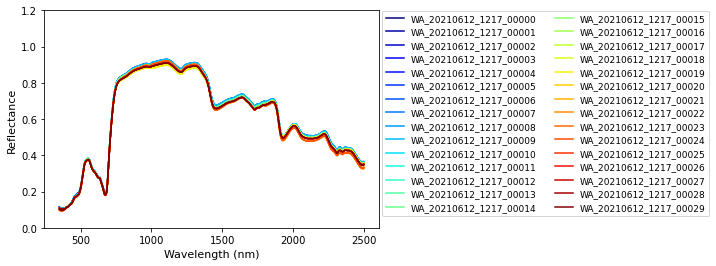

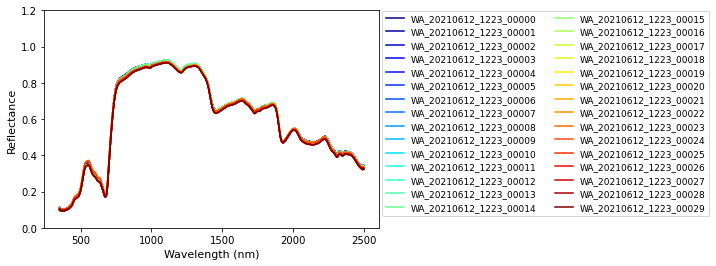

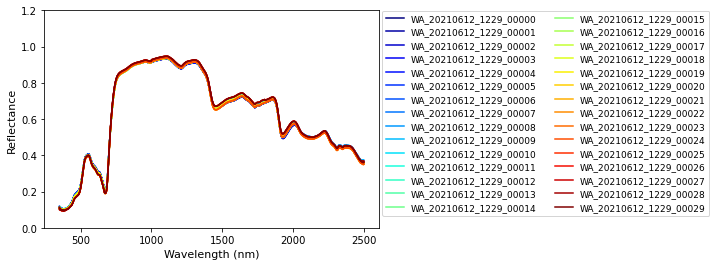

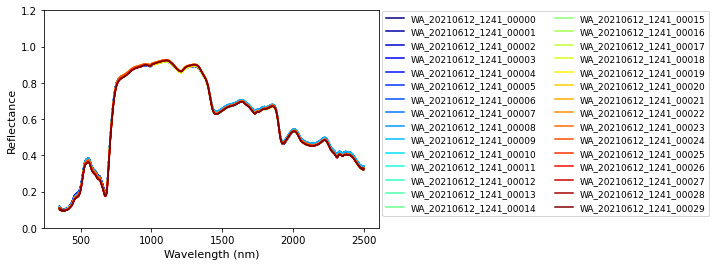

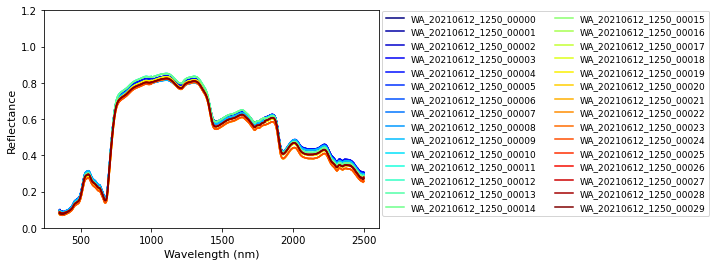

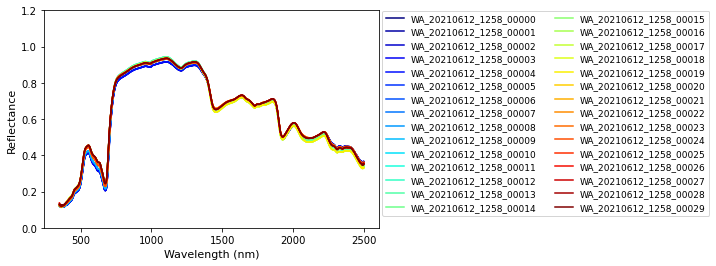

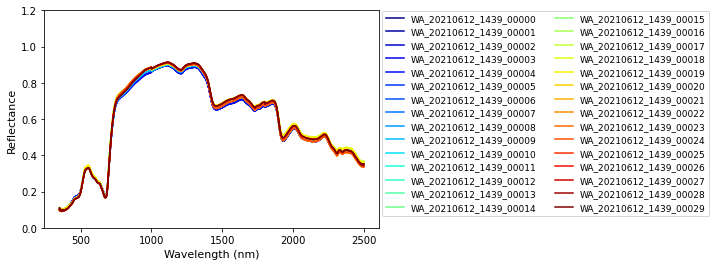

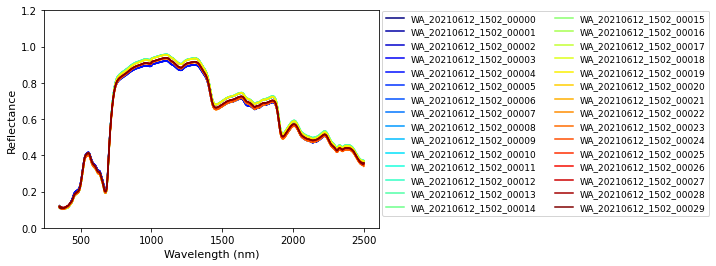

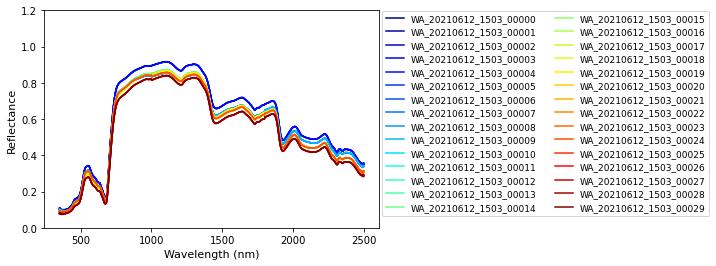

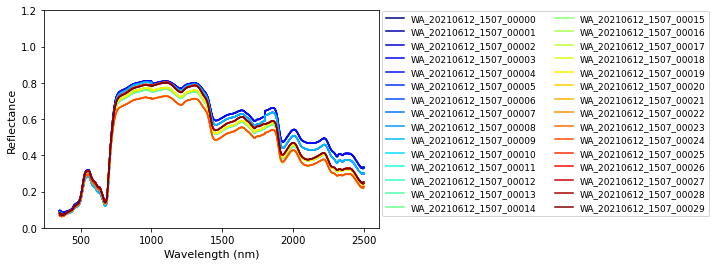

In [6]:
# plotting a single group
for spl_name in group_names.group_name:
    groups[spl_name].plot(figsize=(6, 4), ylim=(0,1.2), cmap='jet')
    plt.xlabel('Wavelength (nm)', fontsize=11)
    plt.ylabel('Reflectance', fontsize=11)
    plt.legend(bbox_to_anchor=(2, 1.02), loc='upper right', ncol=2, fontsize=9)
    plt.show()

No spectrum is excluded


E:\sandbox\conda\envs\pdao\lib\site-packages\specdal\operators\proximal_join.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  isdigit = df.columns.map(str).str.replace('.', '').str.isdigit()


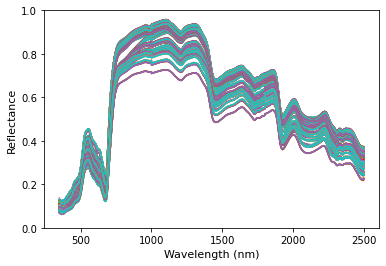

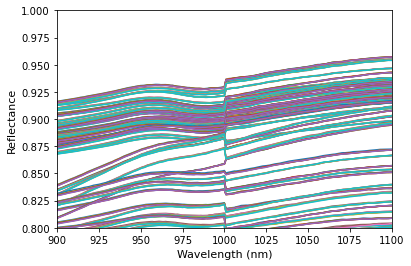

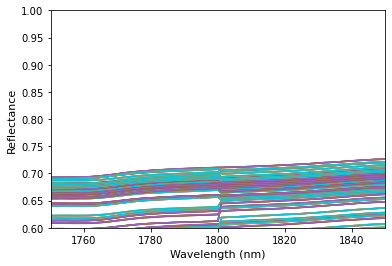

In [7]:
# Filter spectra
from specdal.containers.collection import df_to_collection

# If we want to remove both white and dark reflectance
c_drop = c.data[(c.data[0:] < 1) & (c.data.iloc[350,] > 0.05)]
c_drop = c_drop.dropna(axis=1, how="any")

# Manually drop an outlier spectrum
# List of spectral files to be excluded
from pathlib import Path
drop_file = Path(str(datadir + '/' + 'Bad_spectra.txt'))

if drop_file.is_file() == True:
    drop_fn = pd.read_csv(drop_file)
    drop_spl = list(drop_fn['Bad_file'])
    c_drop = c_drop.drop(columns = drop_spl, axis=1)
    print('List of excluded spectra:')
    print(drop_spl)
else:
    print("No spectrum is excluded")


# Convert dataframe back to collection
c_tran = c_drop.transpose()
c_filter = df_to_collection(c_tran, 'WisAsp', measure_type='pct_reflect')

# Get the list of groups for the calculation of the mean
groups_filter = c_filter.groupby(separator='_', indices=[0, 1, 2])

# Plot spectra
c_filter.plot(figsize=(6, 4), legend=False, ylim=(0, 1))
plt.xlabel('Wavelength (nm)', fontsize=11)
plt.ylabel('Reflectance', fontsize=11)

c_filter.plot(legend=False, xlim=(900, 1100), ylim=(0.8, 1))
plt.xlabel('Wavelength (nm)', fontsize=11)
plt.ylabel('Reflectance', fontsize=11)

c_filter.plot(legend=False, xlim=(1750, 1850), ylim=(0.6, 1))
plt.xlabel('Wavelength (nm)', fontsize=11)
plt.ylabel('Reflectance', fontsize=11)

plt.show()


Calculate the mean spectra

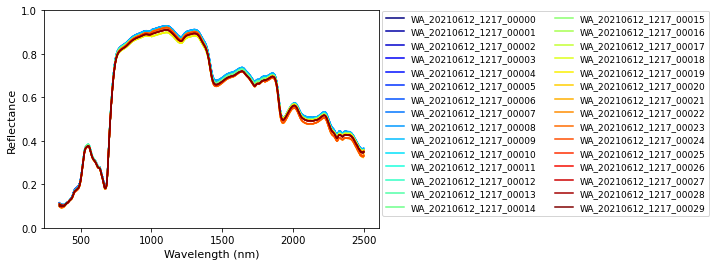

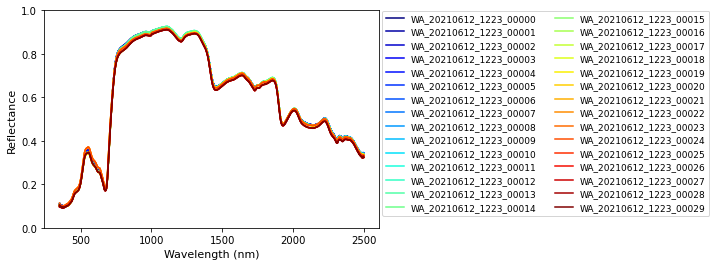

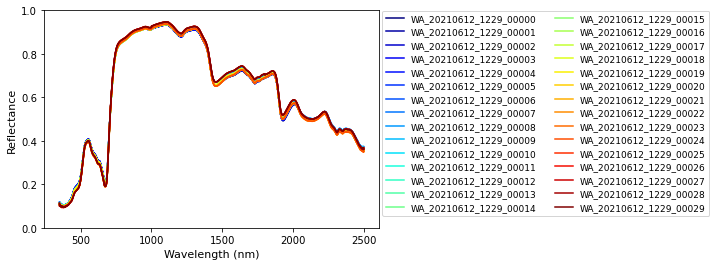

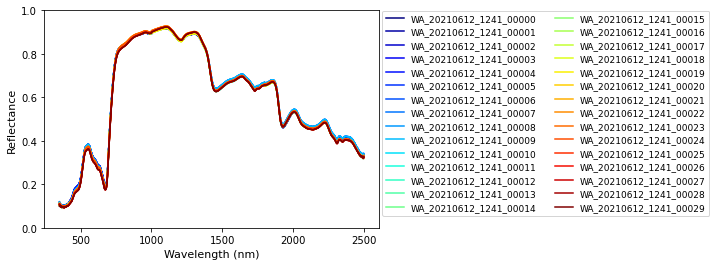

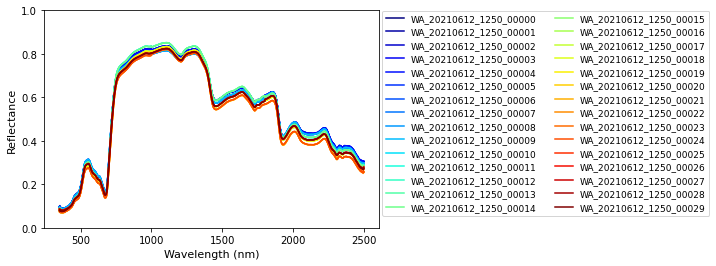

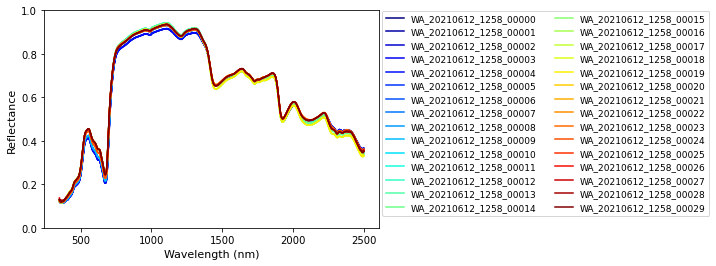

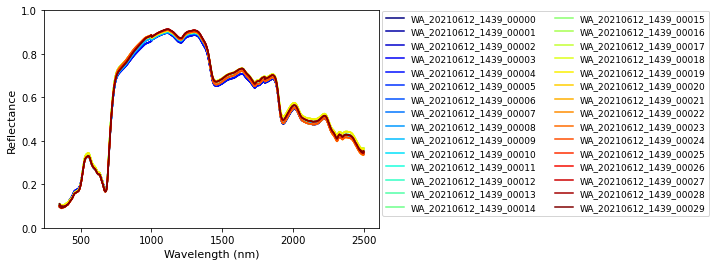

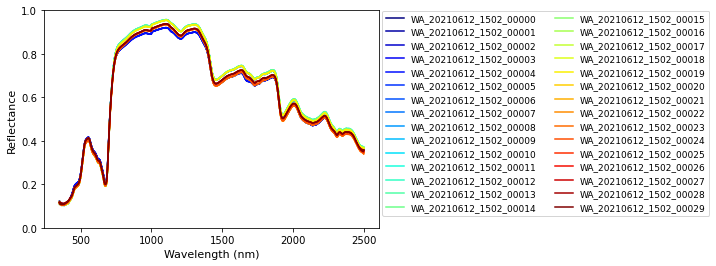

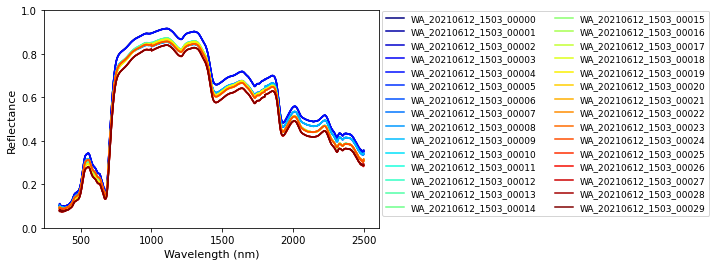

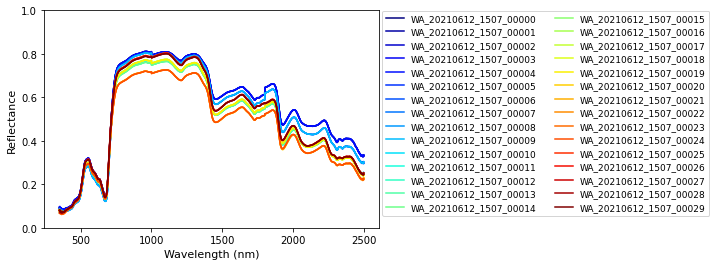

In [8]:
# plotting a single group after removing white and dark reflectance
for spl_name in group_names.group_name:
    groups_filter[spl_name].plot(figsize=(6, 4), ylim=(0,1), cmap='jet')
    plt.xlabel('Wavelength (nm)', fontsize=11)
    plt.ylabel('Reflectance', fontsize=11)
    plt.legend(bbox_to_anchor=(2, 1.02), loc='upper right', ncol=2, fontsize=9)
    plt.show()

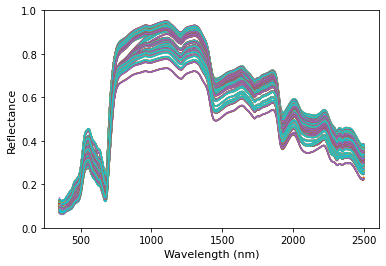

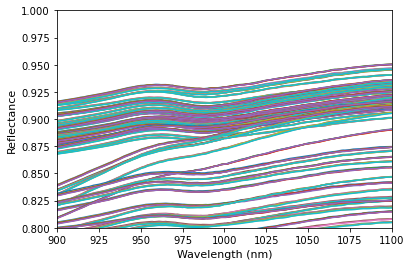

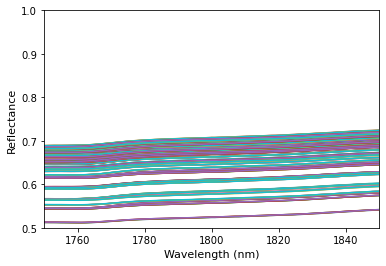

In [9]:
# Apply jump correct
if svc_name == 'svc2040':
    tran_wave = [989.7] # 989.7 nm transition wavelength is for SVC 2040

elif svc_name == 'svc2042':
    tran_wave = [989.8] # 989.8 nm transition wavelength is for SVC 2042

elif svc_name == 'asd':
    tran_wave = [1000, 1800] # 1000, 1800 nm transition wavelength is for the lab ASD
    
# Apply jump correct
c_filter.jump_correct(splices = tran_wave, reference=0)

c_filter.plot(legend=False, ylim=(0, 1))
plt.xlabel('Wavelength (nm)', fontsize=11)
plt.ylabel('Reflectance', fontsize=11)

c_filter.plot(legend=False, xlim=(900, 1100), ylim=(0.8, 1))
plt.xlabel('Wavelength (nm)', fontsize=11)
plt.ylabel('Reflectance', fontsize=11)

c_filter.plot(legend=False, xlim=(1750, 1850), ylim=(0.5, 1))
plt.xlabel('Wavelength (nm)', fontsize=11)
plt.ylabel('Reflectance', fontsize=11)

plt.show()

# Export all the processed spectra
fol_name = os.path.basename(datadir)

# Export the spectra to CSV file in the same folder
c_filter.data.to_csv(datadir + '/' + fol_name + '_Spectra_Original.csv')


In [10]:
# Resample spectra of SVC2040 and SVC2042 to the same wavelengths
from spectral import*
import pandas as pd
from collections import OrderedDict


# Get wavelength ad fwhm of the two SVCs and target wavelength
if resample == True:
    # Read wavelength and fwhm data from file
    wvl_fwhm_ori = pd.read_csv(wave_ln)
    
    if svc_name == 'svc2040':
        wl_svc = wvl_fwhm_ori['wl_svc2040'].dropna()
        fwhm_svc = wvl_fwhm_ori['fwhm_svc2040'].dropna()
    
    elif svc_name == 'svc2042':
        wl_svc = wvl_fwhm_ori['wl_svc2042'].dropna()
        fwhm_svc = wvl_fwhm_ori['fwhm_svc2042'].dropna()
    
    wl_res = wvl_fwhm_ori['wl_res'].dropna()
    fwhm_res = wvl_fwhm_ori['fwhm_res'].dropna()
    
    # Resample spectra
    svc_resample = BandResampler(centers1 = wl_svc, centers2 = wl_res, fwhm1 = fwhm_svc, fwhm2 = fwhm_res)
    c_res = pd.DataFrame(svc_resample(c_filter.data))
    
    c_res.columns = c_filter.data.columns
    c_res.index = wl_res
    c_res.index.name = 'wavelength'
    
    # Convert dataframe back to collection
    c_res_tran = c_res.transpose()
    c_res_final = df_to_collection(c_res_tran, 'WisAsp', measure_type='pct_reflect')
    
    # Export all the processed spectra
    fol_name = os.path.basename(datadir)
    
    # Export the spectra to CSV file in the same folder
    c_res_final.data.to_csv(datadir + '/' + fol_name + '_Spectra_Resampled.csv')
    
    # Plot the resample spectra
    c_res_final.plot(legend=False, ylim=(0, 1))
    c_res_final.plot(legend=False, xlim=(900, 1100), ylim=(0.8, 1))
    c_res_final.plot(legend=False, xlim=(1750, 1850), ylim=(0.5, 1))
    plt.show()
    
else:
    c_res_final = c_filter

Number of remaining spectra of sample WA_20210612_1217 : 25


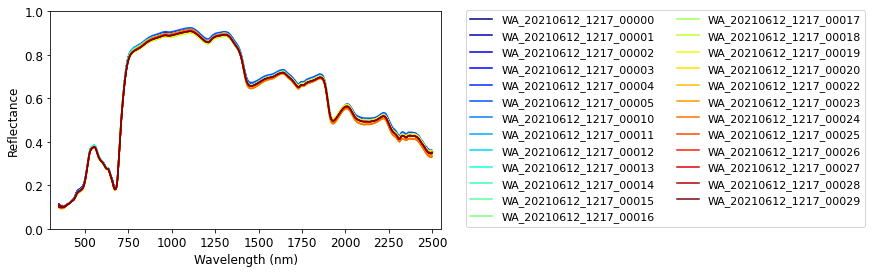

Number of remaining spectra of sample WA_20210612_1223 : 25


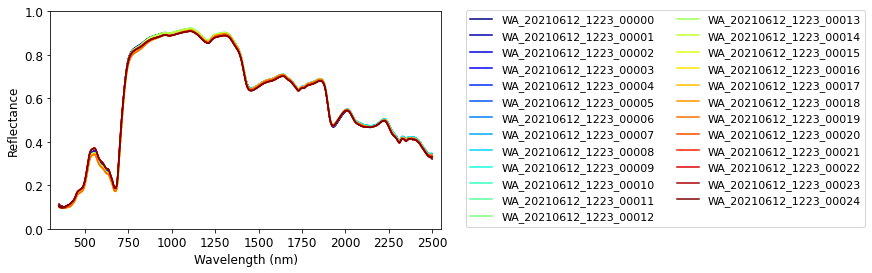

Number of remaining spectra of sample WA_20210612_1229 : 29


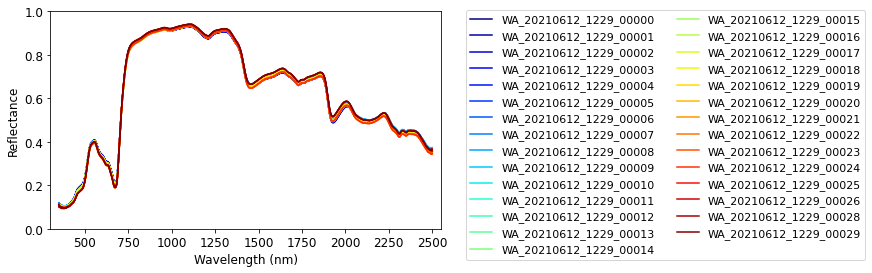

Number of remaining spectra of sample WA_20210612_1241 : 25


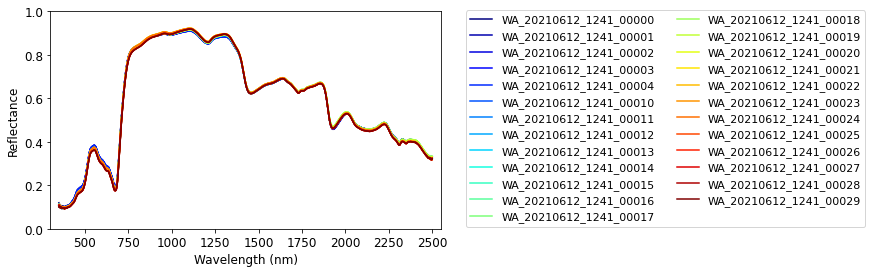

Number of remaining spectra of sample WA_20210612_1250 : 25


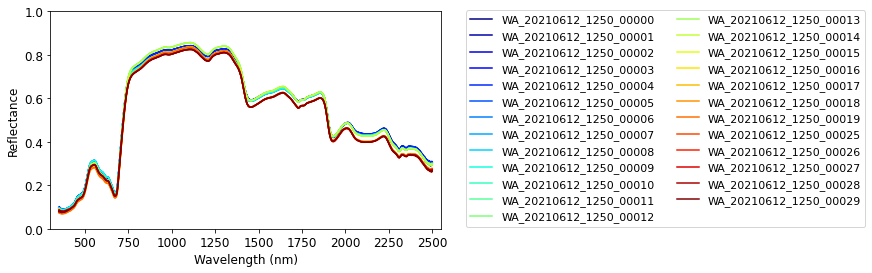

Number of remaining spectra of sample WA_20210612_1258 : 28


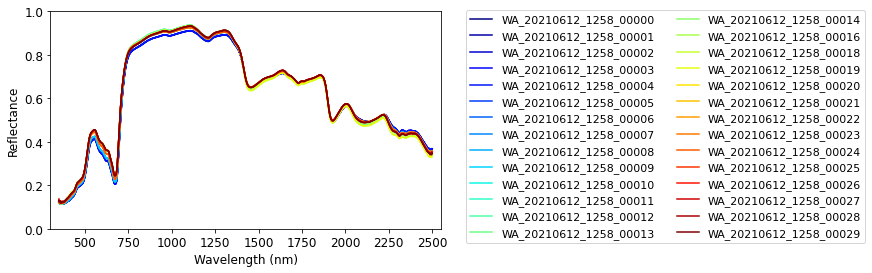

Number of remaining spectra of sample WA_20210612_1439 : 25


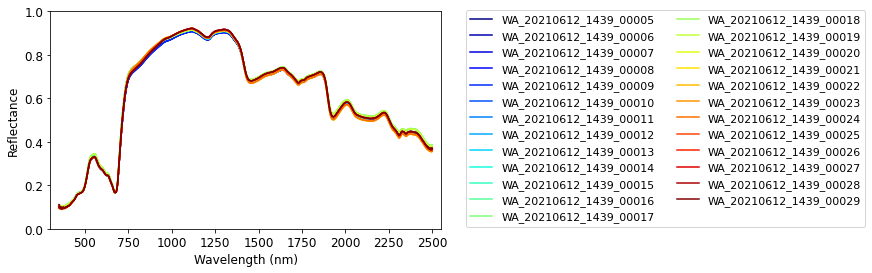

Number of remaining spectra of sample WA_20210612_1502 : 30


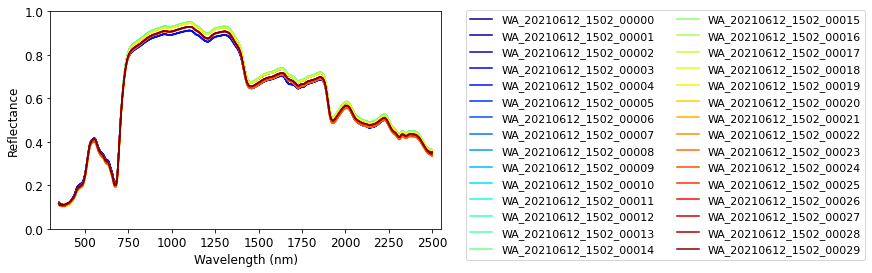

Number of remaining spectra of sample WA_20210612_1503 : 25


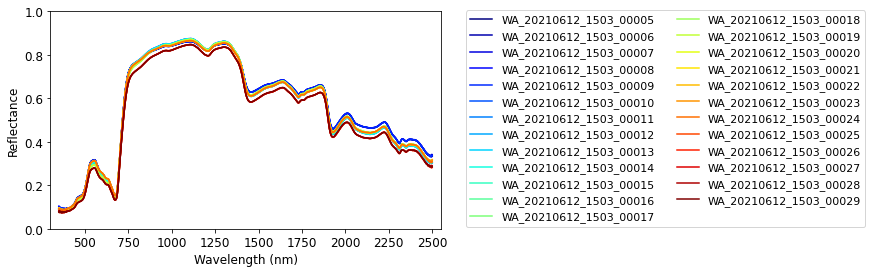

Number of remaining spectra of sample WA_20210612_1507 : 24


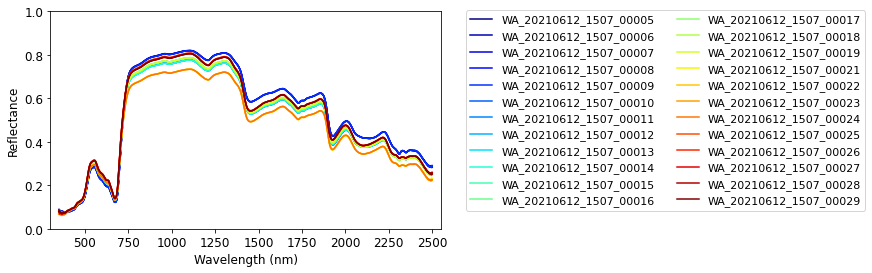

In [11]:
# Filter outliers and calculate the group means and standard deviation
# Get the list of groups for the calculation of the mean
from specdal.filters import filter_std
import warnings

warnings.filterwarnings("ignore")

groups_filter = c_res_final.groupby(separator='_', indices=[0, 1, 2])

# Create groups for mean and std
group_means = sd.Collection(name='Group Means')
group_std = sd.Collection(name='std')

for group_key, group_collection in groups_filter.items():
    good_col, bad_col = filter_std(group_collection, wavelength0=1200, wavelength1=2500, std_thresh=1.5, group='mean')
    print("Number of remaining spectra of sample", group_key, ":", good_col.data.shape[1])
    
    # Print spectra of each group after removing outliers
    good_col.plot(figsize=(7, 4), xlim=(300,2550), ylim=(0, 1), cmap="jet")
    plt.xlabel('Wavelength (nm)', fontsize=12)
    plt.ylabel('Reflectance', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(bbox_to_anchor=(2.1, 1.03), loc='upper right', ncol=2, fontsize=11)
    plt.show()
    
    # Calculate mean and std of filtered collections
    group_means.append(good_col.mean())
    group_std.append(good_col.std())

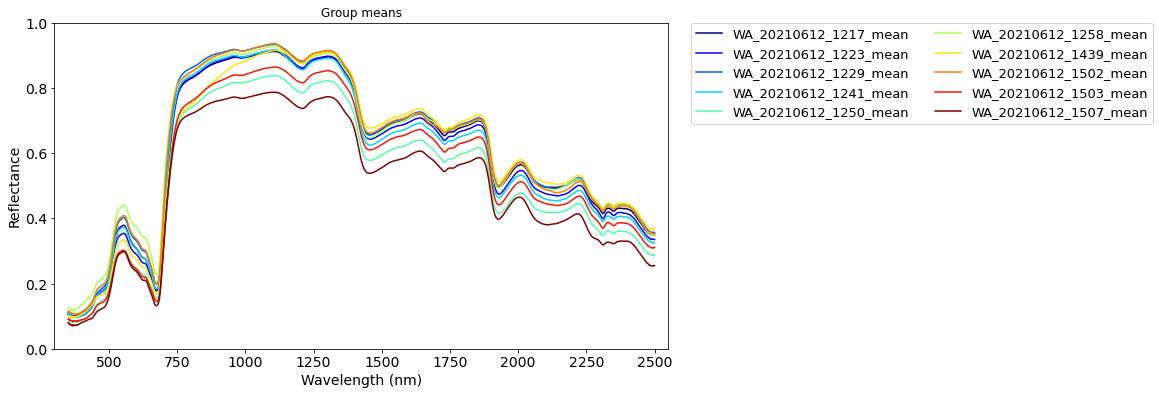

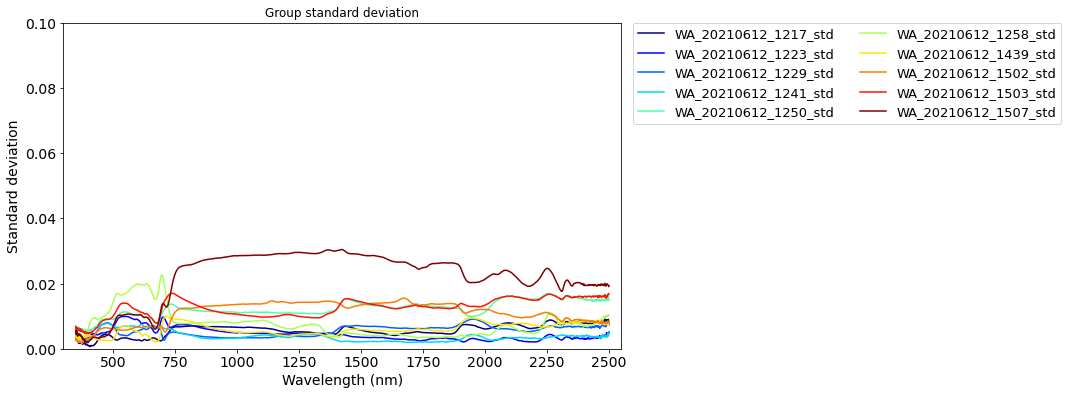

In [12]:
# plot the group means
group_means.plot(legend=False, title='Group means', figsize=(11, 6), xlim=(300,2550), ylim=(0, 1), cmap="jet")
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.8, 1.02), loc='upper right', ncol=2, fontsize=13)
plt.show()

# # plot the group std
group_std.plot(legend=False, title='Group standard deviation', figsize=(10, 6), xlim=(300,2550), ylim=(0, 0.1), cmap="jet")
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Standard deviation', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.8, 1.02), loc='upper right', ncol=2, fontsize=13)
plt.show()

In [13]:
# Export the final mean and std of spectra to CSV
# get the base name of the immediate folder
fol_name = os.path.basename(datadir)

# Export the mean spectra to CSV file in the same folder
group_means.data.to_csv(datadir + '/' + fol_name + '_Spectra_Mean.csv')

# Export the std spectra to CSV file in the same folder
group_std.data.to_csv(datadir + '/' + fol_name + '_Spectra_Std.csv')

In [14]:
# # Copy all the csv ourtput files to a folder
# import shutil
# srcDir = r'D:\WisAsp\AARS_Aspen_SVC2040'
# dstDir = r'D:\vv'
# for root, dirs, files in os.walk(srcDir):
#    for file in files:
#        if file[-4:].lower() == '.csv':
#            shutil.copy(os.path.join(root, file), os.path.join(dstDir, file))